# SOM - Self-Organising Maps - DWELING 
## Preparing the environment

In [1]:
%reset
# from __future__ import division

import numpy as np
from sklearn import preprocessing
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from numpy import *

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento y parametros para trabajar
# this cell is used to import and save the consumption or production data from the dataset

#filename = 'Data/dataGM_excel2.xlsx'
#consumptionDF = pd.read_excel(filename, sheet_name='Consumptie')

file_name = '../Emilio Caba/Final_data_cleaned_missing_houses.csv'
#file_name = '../Emilio Caba/Combined_data.csv'
df = pd.read_csv(file_name)


cons = df.iloc[0:,1:29] #getting the consumption columns from dataset

cons = cons[(cons != 0.0).all(1)] #dropping out all the rows with no consumption (zero)


#cons.tail()
cons.columns

Index(['H01_prod', 'H02_prod', 'H03_prod', 'H04_prod', 'H06_prod', 'H07_prod',
       'H08_prod', 'H09_prod', 'H11_prod', 'H13_prod', 'H15_prod', 'H16_prod',
       'H17_prod', 'H18_prod', 'H19_prod', 'H20_prod', 'H21_prod', 'H22_prod',
       'H23_prod', 'H24_prod', 'H25_prod', 'H26_prod', 'H27_prod', 'H28_prod',
       'H29_prod', 'H31_prod', 'H32_prod', 'H33_prod'],
      dtype='object')

In [3]:
#this cell is used to combine the 2 parts of the full dataframe (production and consumption)
consumption = df.iloc[0:,1:29]
production = df.iloc[0:,29:57]

col_names = ['H0' + str(col) if col < 10 else 'H' + str(col) for col in range(1,29)]

production.columns = col_names
consumption.columns = col_names

production +=1 # avoid getting negative values

result = production - consumption #we create a relation between both dataframes

result.min()

H01    0.089
H02    0.230
H03    0.497
H04    0.360
H05    0.232
H06    0.213
H07    0.533
H08    0.195
H09    0.514
H10    0.174
H11    0.497
H12    0.422
H13    0.570
H14    0.402
H15    0.436
H16    0.422
H17    0.216
H18    0.281
H19    0.377
H20    0.424
H21    0.264
H22    0.326
H23    0.511
H24    0.251
H25    0.257
H26    0.157
H27    0.306
H28    0.446
dtype: float64

In [4]:
#consumptionDF.iloc[4:3076,0:33]
data = result.values
datos = data.transpose()
#datos = np.delete(data, (0,1), axis = 0)
#datos = np.delete(datos, (0), axis = 1)
#datos = np.delete(datos_consumo, (0), axis = 0)
#datos = np.delete(datos, (0,1,2,3), axis = 1)


#datos = pd.DataFrame(datos) #converts to DataFrame

print('with zeros: ' + str(len(datos)))
print(shape(datos))


non_zero_data = datos[datos != 0.0] #dropping all the rows with the entire line filled up with 0

valores_tipo = datos.shape[1]
num_houses = datos.shape[0]

print(non_zero_data)
print('without zeros: ' + str(shape(non_zero_data)))


with zeros: 28
(28, 54745)
[1.031 1.037 1.034 ... 1.474 1.263 1.045]
without zeros: (1532860,)


# SOM SETUP

In [5]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 10
periodo = 1000
learning_rate = 0.2
normalizar_datos = 'true'

In [6]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = valores_tipo
num_datos = num_houses

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa/2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos == 'true':
    datos_norm = (datos-np.min(datos))/(np.max(datos)-np.min(datos))
    #datos_norm = preprocessing.normalize(datos,norm='l2')#l1 vs l2 no sabemos cual es mejor
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy

matriz_pesos = np.random.random((lado_mapa,lado_mapa,valores_tipo))
print(len(matriz_pesos[1]))
print(valores_tipo)

10
54745


# train & classify

In [7]:

# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""

def calcular_bmu(patron_entrada, matriz_pesos, m):
    distancia_minima = math.inf ; #Le asignamos la distancia minima un valor muy alto.
    for x in range(matriz_pesos.shape[0]):#recorremos la matriz
        for y in range(matriz_pesos.shape[1]):
            
            w = matriz_pesos[x, y] 
            raiz_distancia = np.sum((w - patron_entrada) ** 2) 
            for r in range(0, len(w)):
                raiz_distancia = raiz_distancia + (w[r] - patron_entrada[r])**2
            
            if raiz_distancia < distancia_minima:#se calcula la bmu viendo que distancia es menor
                distancia_minima = raiz_distancia;
                global bmu, bmu_idx
                bmu = w;
                bmu_idx = np.array([x, y]);
    
    return(bmu, bmu_idx) #se devuelve el valor de la BMU y sus indices
      

In [8]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""


def variacion_learning_rate(learning_rate, i, periodo): #se calcula mediante la formula de variación del coeficiente de aprendizaje
    return learning_rate * (1 - (i / periodo))
     
    # decay the SOM parameters
    


In [9]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario, i, periodo): #se calcula mediante la formula de variación del vecindario
    return 1 + vecindario * (1 - (i / periodo))
    


In [10]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual): #se calcula mediante la formula del descenso de eta
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

# SOM TRAINING

In [11]:
# Entrena la red con el dataset de entrenamiento
# train the net with the training dataset



for iteracion in range(periodo):
    if iteracion % 20 == 0:
        print(iteracion)
    v = variacion_vecindario(vecindario,iteracion,periodo) #se calcula la variación del vecindario #neighborhood variation is calculated 
    eta = variacion_learning_rate(learning_rate, iteracion, periodo)#se calcula la variación del coeficiente de aprendizaje #the learning coefficient variation is calculated
    entrada = datos_norm[np.random.randint(datos_norm.shape[0])] #se toman los datos necesarios para el entrenamiento #it takes the values to the train
    
    bmu = 0
    bmu_idx = 0
    bmu, bmu_idx = calcular_bmu(entrada, matriz_pesos, num_entradas) #se calcula la BMU para cada caso #it calculates the BMU for each case
    
    
        
    for i in range (lado_mapa): #se recorre la matriz #goes over the full matrix
        for j in range (lado_mapa):
            p=(i,j)
            #calcular distancia entre la neurona i, j a la bmu #calculate the distance between i and j neuron to the BMU
            arrayPes = np.array(p)
            arrayCoord = np.array(bmu_idx)

            dist =   np.sqrt(np.sum((arrayPes-arrayCoord)**2)) #se calcula la distancia euclidea #calculate the euclidean distance


            amortiguacion = decay(dist, v)#se actualiza la amortiguación #we
            if(dist <= vecindario):#se compara para ver si es menor que el vecindario definido
                matriz_pesos[i,j] = matriz_pesos[i,j] + (eta*amortiguacion*(entrada - matriz_pesos[i,j]))
                
                
    
#pintar_mapa(matriz_pesos)


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


## SOM Classification
## Classify training patterns with the newly trained weight matrix

Coordenadas (x,y) de las BMU para cada patron de prueba: 

28
the house: 0 la posicion de la bmu es: [6 5]
the house: 1 la posicion de la bmu es: [9 2]
the house: 2 la posicion de la bmu es: [0 2]
the house: 3 la posicion de la bmu es: [0 3]
the house: 4 la posicion de la bmu es: [4 3]
the house: 5 la posicion de la bmu es: [4 7]
the house: 6 la posicion de la bmu es: [9 0]
the house: 7 la posicion de la bmu es: [5 9]
the house: 8 la posicion de la bmu es: [0 0]
the house: 9 la posicion de la bmu es: [4 3]
the house: 10 la posicion de la bmu es: [0 1]
the house: 11 la posicion de la bmu es: [5 0]
the house: 12 la posicion de la bmu es: [0 0]
the house: 13 la posicion de la bmu es: [5 0]
the house: 14 la posicion de la bmu es: [0 4]
the house: 15 la posicion de la bmu es: [0 9]
the house: 16 la posicion de la bmu es: [9 0]
the house: 17 la posicion de la bmu es: [0 6]
the house: 18 la posicion de la bmu es: [0 3]
the house: 19 la posicion de la bmu es: [3 0]
the house: 20 la posicion de

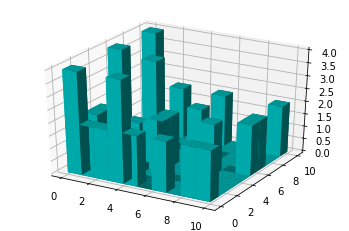

In [12]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada
#Se definen tres matrices y se inicializan a cero para el procesamiento de datos
mapa_clasificacion = np.zeros((lado_mapa, lado_mapa, valores_tipo))
mapa_activaciones = np.zeros((lado_mapa,lado_mapa))
mapa_distancias = np.zeros((lado_mapa,lado_mapa))
activaciones = 0
#Se imprime cada coordenada (x,y) de la BMU para cada patron de prueba

positions = np.zeros((28,3))
print('Coordenadas (x,y) de las BMU para cada patron de prueba: \n')
print(num_houses)
for i in range (0, num_houses):
    bmu, bmu_idx = calcular_bmu(datos_norm[i], matriz_pesos, num_entradas)
    print("the house:", i, "la posicion de la bmu es:",bmu_idx)
    positions[i][0] = i
    positions[i][1] = bmu_idx[0]
    positions[i][2] = bmu_idx[1]
    
    mapa_clasificacion[bmu_idx[0],bmu_idx[1]] = datos_norm[i] # comprobar con la matriz de activacion
    mapa_activaciones[bmu_idx[0],bmu_idx[1]] += 1


    
#Se calcula el numero de clases

for a in range(0,mapa_activaciones.shape[0]):
    for b in range(0, mapa_activaciones.shape[1]):
        clases = np.count_nonzero(mapa_activaciones > 0)
#Se usa el metodo .format() para concatenar un entero con un string   
print('\nEl numero de clases es' + " {}".format(clases))



#Se calcula la distancia media entre todos los patrones de la clase con su vector de pesos 



array_distancias = np.array(lado_mapa)
mapa_distancias_sal = np.zeros((lado_mapa, lado_mapa))
from scipy.spatial import distance #librería para calcular la distancia euclídea
for i in range (num_houses): #se recorre la matriz
    bmu, bmu_idx = calcular_bmu(datos_norm[i], matriz_pesos, num_houses) #se calcula su BMU
    mapa_distancias_sal = distance.euclidean(datos_norm[i], bmu) # se va calculando la distancia euclidea y almacenando en mapa distancias
    
for j in range(lado_mapa):
    for k in range(lado_mapa):
        if mapa_activaciones[j][k] > 0:
            mapa_distancias[j][k] =mapa_distancias_sal / mapa_activaciones[j][k] #se calcula el mapa de distancias medias

n_clases = 0
                
#se imprimen los valores generados
print("Mapa distancias medias\n")           
print(mapa_distancias)  


print("\n Distancia media de la red: ")
activaciones = np.sum(mapa_activaciones)
distancia_med = (np.sum(mapa_distancias))/activaciones
print(distancia_med)


print('\nMapa Activaciones')
print(mapa_activaciones)
print('\nMapa Clasificacion')



#Se calcula distancia media del mapa (Error cuantificación) y Error Topológico y se imprimen 


#Calculo del error topologico. Se definen cuatro variables para el cálculo
y = 0
z = 0
t = 0
no_adya = 0 #contará los elementos no adyacentes

adyacente = False;
for x in range ((num_houses)):
    bmu, bmu_idx = calcular_bmu(datos_norm[x], matriz_pesos, num_entradas)#se calcula la BMU para cada caso
#    print("POKEMON:", datos_pokemon[x][19],"TIPO:",datos_pokemon[x][20], datos_pokemon[x][21], "POSICION BMU:",bmu_idx)#se imprimen los valores obtenidos
    mapa_activaciones[bmu_idx[0], bmu_idx[1]] += 1#se incrementa los valores de mapa_activaciones
    if x > 0:
        for a in [y-1, y, y+1]: #calculo de elementos adyacentes entre si
            for b in [z-1, z, z+1]:
                if bmu_idx[0] == a and bmu_idx[1] == b:
                    adyacente = True;
                    t +=1 #va incrementando si es adyacente
                    
    if adyacente == False:
        no_adya +=1 #calculo de valores no adyacentes
        
    y = bmu_idx[0];
    z = bmu_idx[1];
    
error_topologico = t/activaciones;#calculo del error topológico

 
print("\n\n Error Topológico: ")
print(error_topologico)
           

            
print("\n\n Histograma: ")
            
            
#Se importan las librerías necesarias para crear el histograma en 3D
from mpl_toolkits.mplot3d import Axes3D
#Se crea la figura para copiar los datos como un histograma 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#Se convierten los datos de la matriz en un array para crear el histograma
array = np.array(mapa_activaciones)
#Se convierten los datos como malla para visualizar la base del histograma
x, y = np.meshgrid(np.arange(mapa_activaciones.shape[1]),np.arange(mapa_activaciones.shape[0]))
#Se convierten los datos para trabajar como barras en 3D
x = x.flatten()
y = y.flatten()
z = array.flatten()
ax.bar3d( x,y,np.zeros(len(z)),1, 1, z,color='c' )
#Se pinta el histograma
plt.show()


In [13]:
print(positions)

[[ 0.  6.  5.]
 [ 1.  9.  2.]
 [ 2.  0.  2.]
 [ 3.  0.  3.]
 [ 4.  4.  3.]
 [ 5.  4.  7.]
 [ 6.  9.  0.]
 [ 7.  5.  9.]
 [ 8.  0.  0.]
 [ 9.  4.  3.]
 [10.  0.  1.]
 [11.  5.  0.]
 [12.  0.  0.]
 [13.  5.  0.]
 [14.  0.  4.]
 [15.  0.  9.]
 [16.  9.  0.]
 [17.  0.  6.]
 [18.  0.  3.]
 [19.  3.  0.]
 [20.  0.  8.]
 [21.  4.  4.]
 [22.  2.  0.]
 [23.  9.  9.]
 [24.  6.  9.]
 [25.  3.  4.]
 [26.  9.  5.]
 [27.  2.  3.]]


In [14]:
idx = [4, 9, 11, 13, 29]
final_list = -np.ones((33,3))

k=0
for pos in range(len(final_list)):
    if pos in idx:
        k += 1
    else:
        final_list[pos] = positions[pos-k]
        

final_list = [element[1:3] for element in final_list]


for element in range(len(final_list)):
    if -1 not in final_list[element]:
        print('The house no. ', element+1, ' has been classified as ', str(final_list[element]))
    else:
        print('The house no. ', element+1, ' has not been classified.')

The house no.  1  has been classified as  [6. 5.]
The house no.  2  has been classified as  [9. 2.]
The house no.  3  has been classified as  [0. 2.]
The house no.  4  has been classified as  [0. 3.]
The house no.  5  has not been classified.
The house no.  6  has been classified as  [4. 3.]
The house no.  7  has been classified as  [4. 7.]
The house no.  8  has been classified as  [9. 0.]
The house no.  9  has been classified as  [5. 9.]
The house no.  10  has not been classified.
The house no.  11  has been classified as  [0. 0.]
The house no.  12  has not been classified.
The house no.  13  has been classified as  [4. 3.]
The house no.  14  has not been classified.
The house no.  15  has been classified as  [0. 1.]
The house no.  16  has been classified as  [5. 0.]
The house no.  17  has been classified as  [0. 0.]
The house no.  18  has been classified as  [5. 0.]
The house no.  19  has been classified as  [0. 4.]
The house no.  20  has been classified as  [0. 9.]
The house no.  21